In [1]:
# next step: make script to run all the code in one go

import pandas as pd
import os
import pm4py
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import os
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA



In [2]:
os.chdir(r"C:\Users\PhilippKastenhofer\repositories\pm-road-fines")

#log = pm4py.read_xes('data/Road_Traffic_Fine_Management_Process_cleaned.xes')
#df = pm4py.convert_to_dataframe(log)
labels = pd.read_csv("data/paid.csv").set_index("case:concept:name")
X0 = pd.read_csv("data/0_data.csv").set_index("case:concept:name")
#join X0 and y
data = X0.join(labels)

In [130]:
#df.groupby("case:concept:name").get_group("A100")
#create a new column where diff is catagorized


In [3]:

data["cat_diff"] = pd.cut(data["diff"], bins=[-10000,+10,10000], labels=[1,0])
data["cat_diff"]
data["cat_diff"].value_counts()


0    65633
1    61329
Name: cat_diff, dtype: int64

In [4]:
data.columns
numeric_features = [ "points"]
categorical_features = ["vehicleClass", "article" ]
timestamp_features = ["time:timestamp"]
target = "cat_diff"



In [5]:
X = data[numeric_features + categorical_features + timestamp_features]
y = data[target]

#get dummies of categorical features
X = pd.get_dummies(X, columns=categorical_features)
#convert timestamp to datetime
X["time:timestamp"] = pd.to_datetime(X["time:timestamp"])
#extract features from timestamp, utc = true

X["year"] = pd.to_datetime(X["time:timestamp"], utc=True).dt.year
X["month"] = pd.to_datetime(X["time:timestamp"], utc=True).dt.month
X["day"] = pd.to_datetime(X["time:timestamp"], utc=True).dt.day
X["hour"] = pd.to_datetime(X["time:timestamp"], utc=True).dt.hour
X["weekday"] = pd.to_datetime(X["time:timestamp"], utc=True).dt.weekday
#drop timestamp
X = X.drop("time:timestamp", axis=1)

#standar scale numeric features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
pca = PCA(n_components=0.9)
X = pca.fit_transform(X)
y

case:concept:name
A100      0
A10000    1
A10001    0
A10004    0
A10005    1
         ..
V9995     0
V9996     1
V9997     0
V9998     0
V9999     0
Name: cat_diff, Length: 126962, dtype: category
Categories (2, int64): [1 < 0]

In [10]:
#split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_test

test_indices = y_test.index.to_list()
#save test indices
test_data = pd.DataFrame(test_indices)#.to_csv("data/test_indices.csv", index=False)
test_data.columns = ["case:concept:name"]
test_data.to_csv("data/test_indices.csv", index=False)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=1000,
                       n_jobs=-1, oob_score=True, random_state=42)

In [146]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#apply on test data
y_pred = model.predict(X_test)
probs = model.predict_proba(X_test)
#probs to frame
probs = pd.DataFrame(probs)
#probs.columns = ["prob_0", "prob_1"]
#evaluate
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: ", acc)
print("Precision: ", prec)
print("Recall: ", rec)
print("F1", f1)

#get also metrics on train data
y_pred_train = model.predict(X_train)
acc = accuracy_score(y_train, y_pred_train)
prec = precision_score(y_train, y_pred_train)
rec = recall_score(y_train, y_pred_train)
f1 = f1_score(y_train, y_pred_train)


print("Accuracy: ", acc)
print("Precision: ", prec)
print("Recall: ", rec)
print("F1", f1)

#calculate feature importance
feature_importance = pd.DataFrame(
    model.feature_importances_, columns=["importance"]
)
feature_importance = feature_importance.sort_values("importance", ascending=False)
feature_importance
#set columns of probs
probs.columns = ["paid", "not_paid"]
#join probs to y_test
y_test_w_probs = y_test.to_frame()
y_test_w_probs["probs"] = probs["not_paid"].values
y_test_w_probs


Accuracy:  0.6176505336116253
Precision:  0.5793923381770145
Recall:  0.7241806323784364
F1 0.6437456426815397
Accuracy:  0.6367789384556312
Precision:  0.6011357668067226
Recall:  0.7441888816644994
F1 0.6650566531086578


,cat_diff,probs
case:concept:name,,
S133384,1,0.595546
A32782,1,0.588469
A3729,1,0.653025
S98329,1,0.168358
N53303,1,0.581288
...,...,...
S67290,1,0.417830
N44895,1,0.479084
S50624,0,0.394224


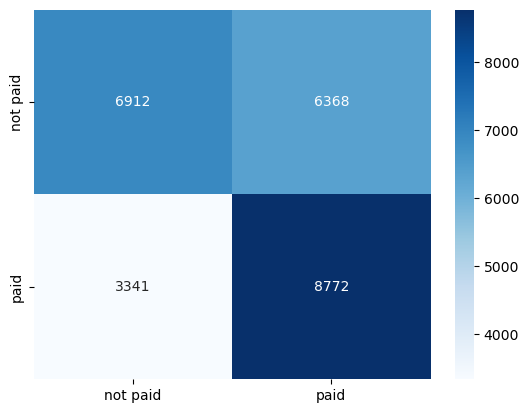

<AxesSubplot:>

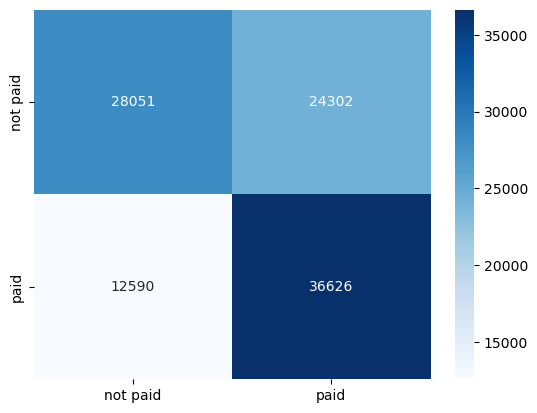

In [139]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
labels = ["not paid", "paid"]
#plot confusion matrix

sns.heatmap(cm, annot=True, cmap = "Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.show()

#also confusion matrix on train data
cm = confusion_matrix(y_train, y_pred_train)
#plot confusion matrix
sns.heatmap(cm, annot=True, cmap = "Blues", fmt="d", xticklabels=labels, yticklabels=labels)